In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from sklearn import linear_model, metrics, ensemble, model_selection, preprocessing, decomposition
from DataLoaderEncode import DataLoader
from traditional import GradientBooster
import matplotlib.pyplot as plt
import itertools
from Bio import SeqIO
import DataLoaderRF
import FeatureSelection

In [2]:
#Load Data and parse in dataframes
files = ['nucleus.fasta.txt', 'cyto.fasta.txt', 'mito.fasta.txt', 'secreted.fasta.txt']
labels = ['nucleus', 'cyto', 'mito', 'secreted']

data = DataLoader(path='./Data/',verbose=True, ignoreX=True)
data.load_files(files, labels)
data.convert_all_to_array()

Loading files...
File 0: nucleus.fasta.txt with label nucleus
File 1: cyto.fasta.txt with label cyto
File 2: mito.fasta.txt with label mito
File 3: secreted.fasta.txt with label secreted
Done
Converting labels, sequences to arrays, and created reversed sequence...
Done


In [3]:
#Trim sequences to manageable length
data.trim_sequences(400)
#Get random ordering
#order = data.get_random_ordering()
#np.savetxt('ordering.csv', order)
order = np.loadtxt('ordering.csv', dtype=int)

Trimming forward and backward sequences to length 400
Done


In [15]:
#Split data into training and test set
train, test = data.create_train_test_set(split=0.15, ordering=order)
train_y, train_x, train_xb, train_len = train
test_y, test_x, test_xb, test_len = test

Splittling data with proportion 0.15 to test set...
Done -> returning train, test


In [16]:
#Split training set into validation and training set
val_split = 0.15
data_size = train_y.shape[0]
val_y = train_y[0:round(data_size*val_split)]
val_x = train_x[0:round(data_size*val_split)]
val_xb = train_xb[0:round(data_size*val_split)]
val_len = train_len[0:round(data_size*val_split)]

train_y = train_y[round(data_size*val_split):]
train_x = train_x[round(data_size*val_split):]
train_xb = train_xb[round(data_size*val_split):]
train_len = train_len[round(data_size*val_split):]


In [11]:
#Helper Functions

def generate_embeddings():
    embeddings = np.array([[0,0,0,0,0], #Padding
                          [71, 6, 1.8, 2.34, 0], 
                          [156, 10.8, -4.5, 2.17, 0],
                          [114,5.4,-3.5,2.02, 0],
                          [115,3,-3.5,1.88, 0],
                          [103,5,2.5,1.96, 0],
                          [129,3.2,-3.5,2.19, 0],
                          [128,5.7,-3.5,2.17, 0],
                          [57,6,-.4,2.34, 0],
                          [137,7.6,-3.2,1.82, 1],
                          [113,6,4.5,2.36, 0],
                          [113,6,3.8,2.36, 0],
                          [128,9.7,-3.9,2.18, 0],
                          [131,5.7,1.9,2.28, 0],
                          [147,5.5,2.8,1.83, 1],
                          [97,6.3,-1.6,1.99, 0],
                          [87,5.7,-.8,2.21, 0],
                          [101,5.6,-.7,2.09, 0],
                          [186,5.9,-.9,2.83, 1],
                          [163,5.7,-1.3,2.20, 1],
                          [99,6,4.2,2.32, 0],
                          [121,5.7,2.5,2.177, 0], #U-> defined weight and charge, same hydro as cysteine
                          [114.5,4.2,-3.5,1.95, 0],#B-> mean of N,D
                          [0,0,0,0,0]]) #X TODO: should define as average
                           
                           
    return embeddings

def rescale_embeddings(embeddings):
    means = embeddings[1:23,:4].mean(axis=0)
    std = embeddings[1:23,:4].std(axis=0)
    return (embeddings[1:23,:4] - means) / std


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [12]:
#Model Functions

#Basic LSTM Encoder
def LSTM_Encoder(fwdcell, bwdcell, inputs, seq_lens):
    outputs, final_state = tf.nn.bidirectional_dynamic_rnn(fwdcell, bwdcell, inputs, dtype=tf.float32, sequence_length=seq_lens)
    final_state = tf.concat([final_state[0].h, final_state[1].h], axis=1)
    return final_state

In [13]:
#Tensorflow Encoder-Decoder Model
tf.reset_default_graph()

#Define Variables
embeddings = generate_embeddings()
embeddings[1:23,:4] = rescale_embeddings(embeddings)
num_hidden_lstm = 64
num_hidden_MLP = 96


#Placeholders
sequences = tf.placeholder(tf.int32, [None,None])
sequences_back = tf.placeholder(tf.int32, [None,None])
labels = tf.placeholder(tf.int32, [None,None])
seq_lengths = tf.placeholder(tf.int32, [None])
dropout_prob_lstm = tf.placeholder(tf.float32)
dropout_prob_mlp = tf.placeholder(tf.float32)

#Get letter embeddings
embeddings_var = tf.get_variable("Embeddings", initializer=embeddings)
sequences_embedded = tf.cast(tf.nn.embedding_lookup(embeddings_var, sequences), tf.float32) # batch size x max length x 5
sequences_embedded_back = tf.cast(tf.nn.embedding_lookup(embeddings_var, sequences_back), tf.float32) # batch size x max length x 5

#LSTM -> start of sequence
fwdcell = tf.contrib.rnn.BasicLSTMCell(num_hidden_lstm, name='fwdcell')
fwdcell = tf.contrib.rnn.DropoutWrapper(fwdcell, input_keep_prob=(1-dropout_prob_lstm))
bwdcell = tf.contrib.rnn.BasicLSTMCell(num_hidden_lstm, name='bwdcell')
bwdcell = tf.contrib.rnn.DropoutWrapper(bwdcell, input_keep_prob=(1-dropout_prob_lstm))
encoded = LSTM_Encoder(fwdcell, bwdcell, sequences_embedded, seq_lengths)

#LSTM -> end of sequence
fwdcell_b = tf.contrib.rnn.BasicLSTMCell(num_hidden_lstm, name='fwdcell_b')
fwdcell_b = tf.contrib.rnn.DropoutWrapper(fwdcell_b, output_keep_prob=(1-dropout_prob_lstm))
bwdcell_b = tf.contrib.rnn.BasicLSTMCell(num_hidden_lstm, name='bwdcell_b')
bwdcell_b = tf.contrib.rnn.DropoutWrapper(bwdcell_b, output_keep_prob=(1-dropout_prob_lstm))
encoded_b = LSTM_Encoder(fwdcell_b, bwdcell_b, sequences_embedded_back, seq_lengths)

#Concatenate start and end representations
encoded = tf.concat([encoded, encoded_b], axis=1)

#MLP Prediction
h = tf.contrib.layers.fully_connected(encoded, num_hidden_MLP)
h = tf.nn.dropout(h, keep_prob=(1-dropout_prob_mlp))
h = tf.contrib.layers.fully_connected(encoded, num_hidden_MLP)
h = tf.nn.dropout(h, keep_prob=(1-dropout_prob_mlp))
h = tf.contrib.layers.fully_connected(h, 4, activation_fn=None)

#Loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=h))
opt = tf.train.AdamOptimizer(0.001).minimize(loss)

#Accuracy
prediction = tf.argmax(h, axis=1)
truth = tf.argmax(labels, axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, truth), dtype=tf.float32))

#Probabilities
prob = tf.nn.softmax(h, axis=1)


In [21]:
e = generate_embeddings()
e[1:23,:4] = rescale_embeddings(e)
e = e[1:23]
pca = decomposition.PCA(n_components=2)
pca.fit_transform(e)
k = list(data.lookup.keys())

IndexError: index 22 is out of bounds for axis 0 with size 22

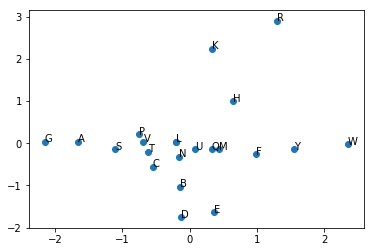

In [25]:
fig, ax = plt.subplots()
ax.scatter(e[:,0], e[:,1])
for i, txt in enumerate(k):
    ax.annotate(txt, (e[i,0],e[i,1]))

In [9]:
#Batch Training using Early Stopping

BATCH_SIZE = 64
EPOCHS = 25
N = len(train_y)
patience = 5
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_val_accuracy = 0
    current_patience = 0
    for epoch in range(0,EPOCHS):
        print("-------------------------------")
        print("Current epoch: {}".format(epoch))
        print("Current Percent ->")
        ordering = np.random.permutation(N)
        total_loss = 0
        for i in range(N // BATCH_SIZE):
            indices = ordering[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
            b_sequences = train_x[indices]
            b_sequences_back = train_xb[indices]
            b_labels = train_y[indices]
            b_seq_lens = train_len[indices]
            feed_dict = {sequences: b_sequences, sequences_back: b_sequences_back, 
                         labels: b_labels, seq_lengths: b_seq_lens, dropout_prob_lstm: 0.2, 
                        dropout_prob_mlp: 0.5}
            _, l = sess.run([opt, loss], feed_dict=feed_dict)
            total_loss += l
            
            if i % 5 == 0:
                print(str(round(i / (N // BATCH_SIZE)*100)) + "->" , end='')
        print("")    
        print("Training epoch total loss: {}".format(total_loss))
        feed_dict = {sequences: val_x, sequences_back: val_xb, labels: val_y, seq_lengths: val_len,
                    dropout_prob_lstm: 0.0, dropout_prob_mlp: 0.0}
        l, a = sess.run([loss, accuracy], feed_dict=feed_dict)
        print("Validation loss {}, accuracy {}".format(l, a))
        if a > best_val_accuracy:
            print("Accuracy improving -> saving model")
            best_val_accuracy = a
            current_patience = 0
            save_path = saver.save(sess, './Model/400_64_96/best2')
        else:
            current_patience += 1
            print("Accuracy decreasing -> current patience {}".format(current_patience))
        if current_patience >= patience:
            print("Training stopping through early stopping")
            

-------------------------------
Current epoch: 0
Current Percent ->
0->5->10->14->19->24->29->34->38->43->48->53->58->62->67->72->77->82->87->91->96->
Training epoch total loss: 115.03407984972
Validation loss 0.9283412098884583, accuracy 0.5476190447807312
Accuracy improving -> saving model
-------------------------------
Current epoch: 1
Current Percent ->
0->5->10->14->19->24->29->34->38->43->48->53->58->62->67->72->77->82->87->91->96->
Training epoch total loss: 100.39822602272034
Validation loss 0.8752578496932983, accuracy 0.5833333134651184
Accuracy improving -> saving model
-------------------------------
Current epoch: 2
Current Percent ->
0->5->10->14->19->24->29->34->38->43->48->53->58->62->67->72->77->82->87->91->96->
Training epoch total loss: 94.75166952610016
Validation loss 0.8168768286705017, accuracy 0.6139456033706665
Accuracy improving -> saving model
-------------------------------
Current epoch: 3
Current Percent ->
0->5->10->14->19->24->29->34->38->43->48->53->58

In [4]:
#Gradient Boosting
GB = GradientBooster()
GB.add_features()
GB.get_labels_and_data()

Loading file: ./Data/nucleus.fasta.txt...
... Success
Loading file: ./Data/cyto.fasta.txt...
... Success
Loading file: ./Data/mito.fasta.txt...
... Success
Loading file: ./Data/secreted.fasta.txt...
... Success
Converting data to pandas DataFrame
Success
Adding Sequence Length...
Success
Numerating Sequences...
Getting Attributes...
Success
Expanding Attribute: Sequence Weights...
Convolving...
k3 Done
k5 Done
k7 Done
Expanding Attribute: Sequence Isoelectric...
Convolving...
k3 Done
k5 Done
k7 Done
Expanding Attribute: Sequence Hyrophobicity...
Convolving...
k3 Done
k5 Done
k7 Done
Expanding Attribute: Sequence Acidity...
Convolving...
k3 Done
k5 Done
k7 Done
Adding Amino Acid Counts...
Success
Adding Percentages...
Success
Extracting aromatic features...
Done
Exploding feature: Amino Acid Percentage
Success
Exploding feature: Amino Acid Percentage Start
Success
Exploding feature: Amino Acid Percentage End
Success


In [2]:
AMINO_VECTOR

NameError: name 'AMINO_VECTOR' is not defined

In [5]:
gb_train_x, gb_train_y, gb_test_x, gb_test_y = GB.create_train_test_set(ordering=order)

In [6]:
model = ensemble.GradientBoostingClassifier(n_estimators=200, subsample=0.8, max_depth=5)
cross_val = model_selection.cross_val_score(model, gb_train_x, gb_train_y, cv=5, verbose=2)

[CV]  ................................................................
[CV] ................................................. , total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ................................................. , total= 1.4min
[CV]  ................................................................
[CV] ................................................. , total= 1.4min
[CV]  ................................................................
[CV] ................................................. , total= 1.4min
[CV]  ................................................................
[CV] ................................................. , total= 1.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.8min finished


In [7]:
cross_val.mean()

0.6920515523422307

In [8]:
model.fit(gb_train_x, gb_train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

In [17]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './Model/400_64_96/best2')
    feed_dict = {sequences: test_x, sequences_back: test_xb, labels: test_y, seq_lengths: test_len,
                dropout_prob_lstm: 0.0, dropout_prob_mlp: 0.0}
    p = sess.run([prob], feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from ./Model/400_64_96/best2


In [18]:
gb_pred = model.predict_proba(gb_test_x)
gb_pred.shape

(1383, 4)

In [19]:
p = p[0]

In [20]:
p.shape

(1383, 4)

In [21]:
pred = gb_pred + p
pred = pred.argmax(axis=1)
pred

array([2, 2, 0, ..., 2, 1, 2], dtype=int64)

In [22]:
(pred == gb_test_y).mean()

0.7288503253796096

In [23]:
#Confision Matrix
cf = metrics.confusion_matrix(gb_test_y, pred)
print(cf)

[[285  23 132   6]
 [ 22 149   5  11]
 [137  16 349  10]
 [  9   3   1 225]]


In [24]:
#F1 Score
f1 = metrics.f1_score(gb_test_y, pred, average='weighted')
f1

0.727772458683401

In [25]:
# Precision and Recall score
precision = metrics.precision_score(gb_test_y, pred, average='weighted')
recall = metrics.recall_score(gb_test_y, pred, average='weighted')

print(precision)
print(recall)

0.727325682379027
0.7288503253796096


In [26]:
probs = (gb_pred + p)/2
probs

array([[3.75355577e-01, 1.36608071e-02, 6.07891448e-01, 3.09213786e-03],
       [8.70086045e-02, 8.17590077e-04, 9.11685146e-01, 4.88665586e-04],
       [7.45644356e-01, 9.80990886e-03, 2.42733949e-01, 1.81178712e-03],
       ...,
       [4.25462720e-01, 2.21895123e-02, 5.47571172e-01, 4.77660780e-03],
       [2.02504204e-01, 6.26590568e-01, 1.56515520e-01, 1.43897026e-02],
       [1.78559498e-01, 3.19615654e-01, 4.93796645e-01, 8.02818551e-03]])

In [27]:
def one_vs_all(focus, labels, probs):
    labels = (labels==focus).astype(int)
    probs = probs[:, focus]
    return labels, probs    

In [28]:
ova_0_labels, ova_0_probs = one_vs_all(0, gb_test_y, probs)
ova_1_labels, ova_1_probs = one_vs_all(1, gb_test_y, probs)
ova_2_labels, ova_2_probs = one_vs_all(2, gb_test_y, probs)
ova_3_labels, ova_3_probs = one_vs_all(3, gb_test_y, probs)

In [29]:
fpr_0, tpr_0, _ = metrics.roc_curve(ova_0_labels, ova_0_probs)
fpr_1, tpr_1, _ = metrics.roc_curve(ova_1_labels, ova_1_probs)
fpr_2, tpr_2, _ = metrics.roc_curve(ova_2_labels, ova_2_probs)
fpr_3, tpr_3, _ = metrics.roc_curve(ova_3_labels, ova_3_probs)
auc_0 = metrics.roc_auc_score(ova_0_labels, ova_0_probs)
auc_1 = metrics.roc_auc_score(ova_1_labels, ova_1_probs)
auc_2 = metrics.roc_auc_score(ova_2_labels, ova_2_probs)
auc_3 = metrics.roc_auc_score(ova_3_labels, ova_3_probs)

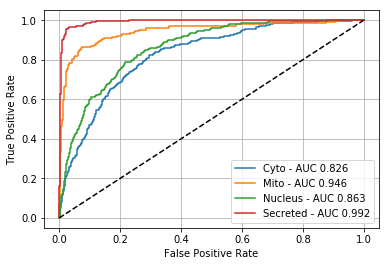

In [30]:
plt.figure()
plt.plot(fpr_0, tpr_0, label='Cyto - AUC {}'.format(round(auc_0,3)))
plt.plot(fpr_1, tpr_1, label='Mito - AUC {}'.format(round(auc_1,3)))
plt.plot(fpr_2, tpr_2, label='Nucleus - AUC {}'.format(round(auc_2,3)))
plt.plot(fpr_3, tpr_3, label='Secreted - AUC {}'.format(round(auc_3,3)))
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend(loc="lower right")
plt.show()

Normalized confusion matrix
[[0.63901345 0.05156951 0.29596413 0.01345291]
 [0.11764706 0.79679144 0.02673797 0.05882353]
 [0.26757812 0.03125    0.68164062 0.01953125]
 [0.03781513 0.01260504 0.00420168 0.94537815]]


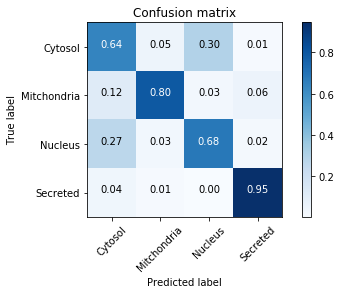

In [31]:
plot_confusion_matrix(cf, ['Cytosol', 'Mitchondria', 'Nucleus', 'Secreted'], normalize=True)

In [32]:
nuc_true = gb_test_y == 2
nuc_pred = pred == 2
cy_true = gb_test_y == 0
cy_pred = pred == 0

In [33]:
nuc_t_nuc_p = nuc_pred * nuc_true
nuc_t_cy_p = nuc_true * cy_pred
cy_t_cy_p = cy_true * cy_pred
cy_t_nuc_p = cy_true * nuc_pred

In [34]:
#Probabilities

print(probs[nuc_t_nuc_p].max(axis=1).mean())
print(probs[nuc_t_cy_p].max(axis=1).mean())
print(probs[cy_t_cy_p].max(axis=1).mean())
print(probs[cy_t_nuc_p].max(axis=1).mean())

0.6833053094949123
0.570073906100947
0.6053619828449631
0.5986111288222693


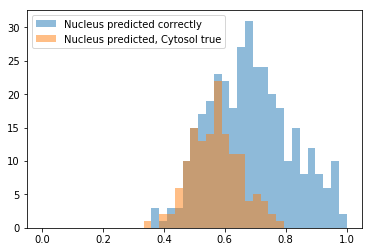

In [35]:
bins = np.linspace(0, 1, 40)
plt.hist(probs[nuc_t_nuc_p].max(axis=1), bins, label ="Nucleus predicted correctly", alpha=0.5)
plt.hist(probs[nuc_t_cy_p].max(axis=1), bins, label ="Nucleus predicted, Cytosol true", alpha=0.5)
plt.legend(loc='upper left')
plt.show()

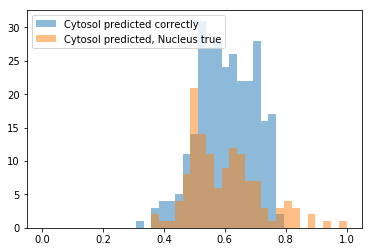

In [36]:
bins = np.linspace(0, 1, 40)
plt.hist(probs[cy_t_cy_p].max(axis=1), bins, label ="Cytosol predicted correctly", alpha=0.5)
plt.hist(probs[cy_t_nuc_p].max(axis=1), bins, label ="Cytosol predicted, Nucleus true", alpha=0.5)
plt.legend(loc='upper left')
plt.show()

In [52]:
correct = gb_test_y == pred
incorrect = gb_test_y != pred
test_lens = np.array(GB.data['Sequence Length'])[order][:round(0.15*len(order))]

(array([48., 48., 43., 38., 56., 59., 72., 56., 44., 39., 50., 61., 46.,
        31., 35., 27., 29., 20., 18., 19., 15.,  9., 16.,  8., 11., 12.,
        10.,  7.,  9.,  9.,  3.,  6.,  6.,  0.,  3.,  5.,  2.,  3.,  1.,
         4.,  5.,  3.,  3.,  0.,  1.,  0.,  1.,  3.,  2.]),
 array([   0.        ,   40.81632653,   81.63265306,  122.44897959,
         163.26530612,  204.08163265,  244.89795918,  285.71428571,
         326.53061224,  367.34693878,  408.16326531,  448.97959184,
         489.79591837,  530.6122449 ,  571.42857143,  612.24489796,
         653.06122449,  693.87755102,  734.69387755,  775.51020408,
         816.32653061,  857.14285714,  897.95918367,  938.7755102 ,
         979.59183673, 1020.40816327, 1061.2244898 , 1102.04081633,
        1142.85714286, 1183.67346939, 1224.48979592, 1265.30612245,
        1306.12244898, 1346.93877551, 1387.75510204, 1428.57142857,
        1469.3877551 , 1510.20408163, 1551.02040816, 1591.83673469,
        1632.65306122, 1673.46938776, 171

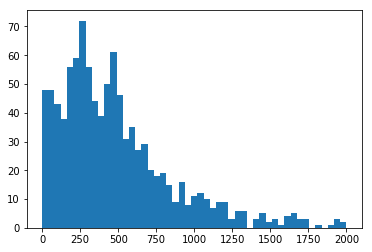

In [75]:
correct_lens = test_lens[correct]
incorrect_lens = test_lens[incorrect]
bins = np.linspace(0,2000, 50)
plt.hist(correct_lens, bins)

In [110]:
bins = [0, 50,250,500,750,1000,1250,1500,2000,3000,15000]
correct_hist = np.histogram(correct_lens, bins)
incorrect_hist = np.histogram(incorrect_lens, bins)
proportion_lens = incorrect_hist[0] / (correct_hist[0] + incorrect_hist[0])
proportion_lens

array([0.03571429, 0.26627219, 0.2370892 , 0.3       , 0.39130435,
       0.28947368, 0.29032258, 0.325     , 0.38461538, 0.2       ])

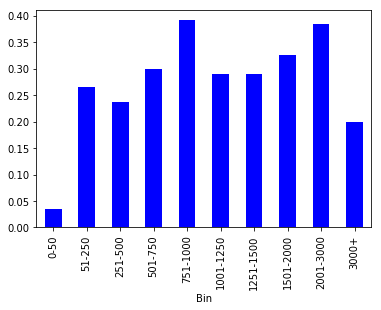

In [118]:
x_axis = ['0-50', '51-250', '251-500', '501-750', '751-1000', '1001-1250' ,'1251-1500','1501-2000','2001-3000','3000+']
#x_axis = ['50', '250', '500', '750', '1000', '1250' ,'1500','2000','3000','3000+']
df = pd.DataFrame(proportion_lens)
df['Bin'] = x_axis
#plt.bar(x_axis, proportion_lens)
df.plot(x='Bin', y=0, kind='bar', legend=False, color='b')

In [ ]:
#Blind Test

In [58]:
test_data = DataLoader(path='./Data/',verbose=True, ignoreX=True)
test_data.load_files(['blind.fasta.txt'], ['Blind'])
test_data.convert_all_to_array()
test_data.trim_sequences(400)
blind_test_x = test_data.sequences
blind_test_xb = test_data.sequences_backwards
blind_test_lens = test_data.seq_lengths

Loading files...
File 0: blind.fasta.txt with label Blind
Done
Converting labels, sequences to arrays, and created reversed sequence...
Done
Trimming forward and backward sequences to length 400
Done


In [59]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './Model/400_64_96/best2')
    feed_dict = {sequences: blind_test_x, sequences_back: blind_test_xb, seq_lengths: blind_test_lens,
                dropout_prob_lstm: 0.0, dropout_prob_mlp: 0.0}
    blind_p = sess.run([prob], feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from ./Model/400_64_96/best2


In [69]:
test_data_2 = DataLoaderRF.DataLoader(path='./Data/')
test_data_2.load_files(['blind.fasta.txt'], ['Blind'])
test_data_2.convert_to_df()

Loading file: ./Data/blind.fasta.txt...
... Success
Converting data to pandas DataFrame
Success
Example data:
   Label                                           Sequence
0  Blind  MESKGASSCRLLFCLLISATVFRPGLGWYTVNSAYGDTIIIPCRLD...
1  Blind  MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...
2  Blind  MDSRICTSFARLMASALCVSTLLVTAMPFDLRRGSSDTDLDLQGHV...
3  Blind  MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINVP...
4  Blind  MNPQIRNPMERMYRDTFYDNFENEPILYGRSYTWICYEVKIKRGRS...


In [70]:
#Feature Selection

FeatureSelection.sequence_length(test_data_2.data)
FeatureSelection.numerate_sequence_and_attributes(test_data_2.data)
FeatureSelection.expand_attributes(test_data_2.data)
FeatureSelection.amino_acid_count(test_data_2.data)
FeatureSelection.amino_acid_percentage(test_data_2.data)
FeatureSelection.aromatic_percentage(test_data_2.data)
test_data_2.data = FeatureSelection.explode_feature(test_data_2.data, 'Amino Acid Percentage')
test_data_2.data = FeatureSelection.explode_feature(test_data_2.data, 'Amino Acid Percentage Start')
test_data_2.data = FeatureSelection.explode_feature(test_data_2.data, 'Amino Acid Percentage End')

Adding Sequence Length...
Success
Numerating Sequences...
Getting Attributes...
Success
Expanding Attribute: Sequence Weights...
Convolving...
k3 Done
k5 Done
k7 Done
Expanding Attribute: Sequence Isoelectric...
Convolving...
k3 Done
k5 Done
k7 Done
Expanding Attribute: Sequence Hyrophobicity...
Convolving...
k3 Done
k5 Done
k7 Done
Expanding Attribute: Sequence Acidity...
Convolving...
k3 Done
k5 Done
k7 Done
Adding Amino Acid Counts...
Success
Adding Percentages...
Success
Extracting aromatic features...
Done
Exploding feature: Amino Acid Percentage
Success
Exploding feature: Amino Acid Percentage Start
Success
Exploding feature: Amino Acid Percentage End
Success


In [74]:
#Prepare data for GB

features = ['Sequence Length Norm', 'Sequence Weights_mean', 'Sequence Weights_std', 'Sequence Isoelectric_mean',
    'Sequence Isoelectric_std', 'Sequence Hyrophobicity_mean','Sequence Hyrophobicity_std', 
    'Sequence Acidity_mean','Sequence Acidity_std','Sequence Aromatic Percentage',
    'Sequence Aromatic Percentage Start', 'Sequence Aromatic Percentage End']

features = features + ['Amino Acid Percentage_' + str(x) for x in range(22)] #Using 22 since X ignored
features = features + ['Amino Acid Percentage Start_' + str(x) for x in range(22)]
features = features + ['Amino Acid Percentage End_' + str(x) for x in range(22)]

conv_features = []
for col in test_data_2.data.columns:
    if 'k3_' in col or 'k5_' in col or 'k7_' in col:
        conv_features.append(col)
features = features + conv_features

test_data_2.X = test_data_2.data[features]
test_data_2.Y = test_data_2.data['Label']
LE = preprocessing.LabelEncoder()
test_data_2.Y = LE.fit_transform(test_data_2.Y)

In [77]:
test_data_2.Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [88]:
#Prediction
blind_gb_pred = model.predict_proba(test_data_2.X)
blind_prediction_probs = (blind_gb_pred + blind_p)/2
blind_predictions = blind_prediction_probs.argmax(axis=2)

In [90]:
blind_predictions

array([[3, 3, 3, 2, 2, 2, 0, 0, 0, 1, 3, 1, 3, 3, 2, 2, 0, 2, 0, 2]],
      dtype=int64)

In [106]:
blind_prediction_probs

array([[[3.03783087e-01, 9.22152936e-02, 1.25376512e-01, 4.78625137e-01],
        [5.40257621e-02, 9.35462542e-02, 5.67211587e-02, 7.95706816e-01],
        [8.65689536e-02, 1.43541690e-01, 1.11223721e-01, 6.58665630e-01],
        [3.54198912e-01, 3.17565841e-02, 6.03169251e-01, 1.08752422e-02],
        [3.42593292e-01, 7.06714813e-02, 5.76035400e-01, 1.06998086e-02],
        [1.84378803e-01, 2.63116198e-03, 8.10486143e-01, 2.50388759e-03],
        [6.56240333e-01, 1.16773070e-01, 2.22064707e-01, 4.92191274e-03],
        [6.80397477e-01, 6.81510328e-03, 3.08217377e-01, 4.57002595e-03],
        [7.45881940e-01, 7.67638473e-02, 1.74946308e-01, 2.40786541e-03],
        [1.94985078e-01, 6.68883846e-01, 8.50524320e-02, 5.10786496e-02],
        [2.97746013e-01, 2.72738069e-01, 1.30402400e-01, 2.99113493e-01],
        [2.28894225e-01, 3.85123909e-01, 3.80414018e-01, 5.56784377e-03],
        [6.11052992e-03, 1.78964114e-04, 6.48031924e-03, 9.87230177e-01],
        [3.73378627e-02, 1.50697028e-0

In [104]:
identifiers = []
with open('./Data/blind.fasta.txt', 'r' ) as f:
    content = SeqIO.parse(f, 'fasta')
    for record in content:
        identifier = record.id
        identifiers.append(identifier)

classes = ['Cytosol', 'Mitochondria', 'Nucleus', 'Secreted']

In [126]:
for i in range(20):
    c = classes[blind_predictions[0,i]]
    conf = str(round(blind_prediction_probs[0,i,:].max()*100,2))
    id = identifiers[i]
    print("{} & {} & {} \\\\".format(id,c,conf))

SEQ677 & Secreted & 47.86 \\
SEQ231 & Secreted & 79.57 \\
SEQ871 & Secreted & 65.87 \\
SEQ388 & Nucleus & 60.32 \\
SEQ122 & Nucleus & 57.6 \\
SEQ758 & Nucleus & 81.05 \\
SEQ333 & Cytosol & 65.62 \\
SEQ937 & Cytosol & 68.04 \\
SEQ351 & Cytosol & 74.59 \\
SEQ202 & Mitochondria & 66.89 \\
SEQ608 & Secreted & 29.91 \\
SEQ402 & Mitochondria & 38.51 \\
SEQ433 & Secreted & 98.72 \\
SEQ821 & Secreted & 95.06 \\
SEQ322 & Nucleus & 74.96 \\
SEQ982 & Nucleus & 93.01 \\
SEQ951 & Cytosol & 61.1 \\
SEQ173 & Nucleus & 51.49 \\
SEQ862 & Cytosol & 58.05 \\
SEQ224 & Nucleus & 45.89 \\
